<a href="https://colab.research.google.com/github/i-SanMartin/FastAI/blob/main/04_MNIST_Basics/Linear_Regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [194]:
!pip install -Uqq fastbook fastai==2.2.5
import fastbook
fastbook.setup_book()

In [195]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f704d128ed0>,
 torch.Size([12396, 784]),
 torch.Size([12396, 1]))

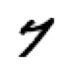

In [196]:
#Download training data
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
path.ls()
(path/'train').ls()
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([0]*len(stacked_threes)+ [1]*(len(stacked_sevens))).unsqueeze(1)
show_image(stacked_sevens[1]*255), train_x.shape, train_y.shape

In [197]:
#Download validation data
threes = (path/'valid'/'3').ls().sorted()
sevens = (path/'valid'/'7').ls().sorted()
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
stacked_sevens = torch.stack(seven_tensors[0: 600]).float()/255
stacked_threes = torch.stack(three_tensors[0: 600]).float()/255
valid_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
valid_y = tensor([0]*len(stacked_threes)+ [1]*(len(stacked_sevens))).unsqueeze(1)

In [198]:
#Function to create weight and bias
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [199]:
#Create weight and bias
weights = init_params((28*28,1))
bias = init_params(1)
weights.shape, bias

(torch.Size([784, 1]), tensor([0.0849], requires_grad=True))

In [200]:
#Create dataset with training data
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([0]))

In [201]:
#Create DataLoader of size 256 with dataset
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [202]:
#Create datase anda dataloader with validation data
valid_dset = list(zip(valid_x,valid_y))
valid_dl = DataLoader(dset, batch_size=256)

In [203]:
#Take a small batch of the datset
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [204]:
#Function to predict
def linear1(xb): return xb@weights + bias

In [205]:
#Make some predictions
preds = linear1(batch)
preds

tensor([[ -5.5905],
        [  1.8283],
        [-12.6169],
        [-11.7690]], grad_fn=<AddBackward0>)

In [206]:
#Loss function
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [207]:
#Calculate some losses
loss = mnist_loss(preds, train_y[:4])
loss

tensor(-7.0370, grad_fn=<MeanBackward0>)

In [208]:
#Calculate gradients
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(0.1511), tensor([1.]))

In [209]:
#Function to calculate gradients
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [210]:
#Try function (put gradients to 0, backward() acumulates it in tensor.grad)
weights.grad.zero_()
bias.grad.zero_()

calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(0.1511), tensor([1.]))

In [211]:
#Function to train on epoch
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [212]:
#See some predictions' result
(preds>0.0).float() == train_y[:4]

tensor([[ True],
        [False],
        [ True],
        [ True]])

In [213]:
#Function to see the accuracy of a batch
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [214]:
#Try the function
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.7500)

In [215]:
#Function to validate the accuracy of all the validatin DataLoader
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [216]:
#Try the function
validate_epoch(linear1)

0.4196

In [217]:
#train one epoch and validate
lr = 0.5
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.9424

In [218]:
#train 20 epchs
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.9541 0.9569 0.9576 0.9582 0.9593 0.9597 0.96 0.9603 0.9603 0.9605 0.9607 0.9607 0.9607 0.9607 0.9608 0.9608 0.9609 0.9609 0.9611 0.9611 